# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

# Load the clean data

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from preprocess_data import preprocess

# magic word for producing visualizations in notebook
%matplotlib inline

seed = 42

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
mailout_train = pd.read_csv('data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

d:\Code\udacity\udacity_ds_capstone\.venv\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
mailout_train = preprocess(mailout_train)

	Raw data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB

*** Dropping columns/rows and imputing missing values...
	Missing values in df before imputing: 2173085
	Missing values in df now: 0

	Before optimization:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42962 entries, 1763 to 69224
Columns: 294 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: datetime64[ns](1), float64(261), int64(30), object(2)
memory usage: 96.7+ MB

	After optimization:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42962 entries, 1763 to 69224
Columns: 294 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: int16(5), int64(1), int8(286), object(2)
memory usage: 13.4+ MB


# Initial modeling
Let's try different model architectures with as little preprocessing as possible (just basic scaling and encoding only string columns)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [5]:
cat_cols = pd.read_csv('data/clean/cat_cols.csv', header=None)[0].tolist()
azdias_encoded_cols = pd.read_csv('data/clean/azdias_encoded_cols.csv', header=None)

from joblib import load, dump
pca_pipeline = load('models/pca_pipeline.joblib')
clustering_pipeline = load('models/clustering_pipeline.joblib')

def split_xy(df, target_col='RESPONSE'):
    """
    Splits a DataFrame's inputs and targets based on a target col name.
    Returns a copy of the slices.
    """
    return df.drop(target_col, axis=1).copy(), df[target_col].copy()

In [6]:
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

The dataset is **extremely unbalanced** (~80 to 1 negative to positive samples ratio)

In [7]:
# Get only non-numeric columns for one hot encoder
obj_cols = mailout_train.select_dtypes(include='object').columns

minimal_preprocessing_pipeline = Pipeline([
    ('col_transformer', ColumnTransformer([
        ('one_hot', OneHotEncoder(), obj_cols)
    ], remainder='passthrough')),
    ('scaler', StandardScaler())
])

In [8]:
X, y = split_xy(mailout_train)
X.shape

(42962, 293)

Fitting LinearRegression
LinearRegression got a ROC AUC score of 0.6243786334354623

------------------------------
Fitting SVR
SVR got a ROC AUC score of 0.5607964588734387

------------------------------
Fitting RandomForestRegressor
RandomForestRegressor got a ROC AUC score of 0.6326871710267892

------------------------------
Fitting GradientBoostingRegressor
GradientBoostingRegressor got a ROC AUC score of 0.6746062141566501

------------------------------
Fitting XGBRegressor
XGBRegressor got a ROC AUC score of 0.588019974074947

------------------------------
Fitting MLPRegressor
MLPRegressor got a ROC AUC score of 0.5389705593526593

------------------------------


,LinearRegression,SVR,RandomForestRegressor,GradientBoostingRegressor,XGBRegressor,MLPRegressor
roc_auc_score,0.624379,0.560796,0.632687,0.674606,0.588020,0.538971
mean_squared_error,0.012308,0.017727,0.012753,0.012290,0.013689,0.014249


<AxesSubplot:>

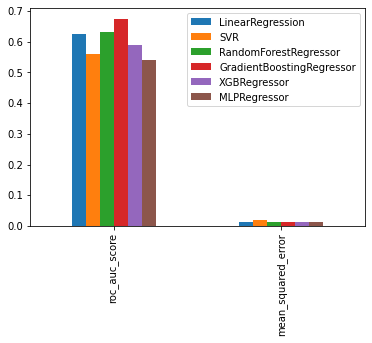

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, test_size=.3)

from evaluation import evaluate_predictions
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

regressors = [
    LinearRegression(),
    SVR(), 
    RandomForestRegressor(random_state=seed), 
    GradientBoostingRegressor(random_state=seed), 
    XGBRegressor(random_state=seed, use_label_encoder=False),
    MLPRegressor(hidden_layer_sizes=(64, 32), learning_rate='adaptive', solver='adam')
]

def train_multiple(regressors, X_train, X_test, y_train, y_test, preprocessing_step=StandardScaler()):
    """
    Fits multiple model architectures on the provided X_train, y_train arrays, testing predictions with the X_test, y_test arrays.
    Returns a dataframe containing test metrics for each model in the `regressors` iterable.
    """
    names = [clf.__class__.__name__ for clf in regressors]
    results = {}

    for name, clf in zip(names, regressors):
        print(f'Fitting {name}')
        pipeline = Pipeline([
            ('preprocessing', preprocessing_step),
            ('clf', clf)
        ])

        pipeline.fit(X_train, y_train.values)
        y_pred = pipeline.predict(X_test)
        results[name] = evaluate_predictions(y_test, y_pred, report=False, plot=False, metrics=[roc_auc_score, mean_squared_error])
        print(name, 'got a ROC AUC score of', results[name]['roc_auc_score'])
        print('\n------------------------------')

    return pd.DataFrame(results)

results = train_multiple(regressors, X_train, X_test, y_train, y_test, preprocessing_step=minimal_preprocessing_pipeline)
display(results)

results.plot.bar()

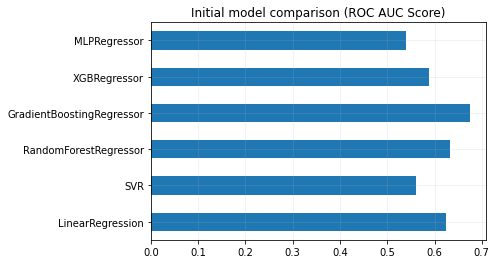

In [11]:
results.loc['roc_auc_score'].plot.barh(title='Initial model comparison (ROC AUC Score)')
plt.grid(alpha=.2)

In [51]:
result_history = {}
result_history['Default GB'] = results.loc['roc_auc_score', 'GradientBoostingRegressor']

# Feature engineering
Let's one-hot encode every categorical feature and add our clustering results as features as well.

We'll start by setting up some functions to aid in training, cross-validating and inspecting our Gradient Boosting model.

In [52]:
from sklearn.model_selection import cross_val_score
import seaborn as sns
sns.set_context('paper', font_scale=.8)

def plot_feature_importances(estimator, onehot, cols, cat_cols):
    """Takes an estimator and an optional one hot encoder to generate an encoded feature importance plot"""
    if onehot is not None:
        transformed_col_names = list(onehot.get_feature_names(cat_cols)) + list([c for c in cols if c not in cat_cols])
    else:
        transformed_col_names = cols

    feat_imp = pd.Series(estimator.feature_importances_, transformed_col_names).sort_values(ascending=False)
    feat_imp.plot.bar(title='Feature Importances', figsize=(35, 7))
    plt.gcf().tight_layout()
    plt.ylabel('Feature Importance Score');
    
    return feat_imp


def fit_model(model, df, cols, target_col, metrics=[roc_auc_score], perform_cv=True, print_feat_importance=True, cv_folds=5, model_name='model', cat_cols=[]):
    """
    Fits a decision tree based ensemble in a pipeline on the provided dataframe with the provided columns. 
    Performs Stratified CV with `cv_folds` folds if required by the `perform_cv` argument.
    Plots a feature importance graph if required by the `print_feat_importance` argument.
    """
    model.fit(df[cols], df[target_col])

    train_preds = model.predict(df[cols])
    train_results = pd.DataFrame(pd.Series({metric.__name__: metric(df[target_col], train_preds) for metric in metrics}, name=model_name))
    print('Training results (same dataset train/test):')
    print(train_results)

    if perform_cv:
        cv_score = cross_val_score(model, df[cols], df[target_col], cv=cv_folds, scoring='roc_auc')
        cv_results = pd.DataFrame(cv_score, index=list(range(cv_folds))).describe()
        print(f'CV Results ({cv_folds} folds):')
        print(cv_results)
    else:
        cv_results = []

    if print_feat_importance:
        if cat_cols:
            onehot = model.steps[0][1].steps[0][1].transformers[0][1]
            estimator = model.steps[-1][1]
            onehot.fit(df[cat_cols])
            plot_feature_importances(estimator, onehot, cols, cat_cols)
        else:
            estimator = model.steps[-1][1]
            plot_feature_importances(estimator, None, cols, cat_cols)

    return model, cv_results

In [ ]:
# Generate cluster features (categorical)
target_col = 'RESPONSE'
cluster_col = pd.Series(clustering_pipeline.predict(mailout_train.drop(target_col, axis=1)), mailout_train.index, name='GB_CLUSTER')

# Append GB_CLUSTER to training dataset
mailout_train['GB_CLUSTER'] = cluster_col

Training results (same dataset train/test):
                  model
roc_auc_score  0.834069
CV Results (5 folds):
              0
count  5.000000
mean   0.678562
std    0.034519
min    0.628649
25%    0.674167
50%    0.680620
75%    0.683636
max    0.725738


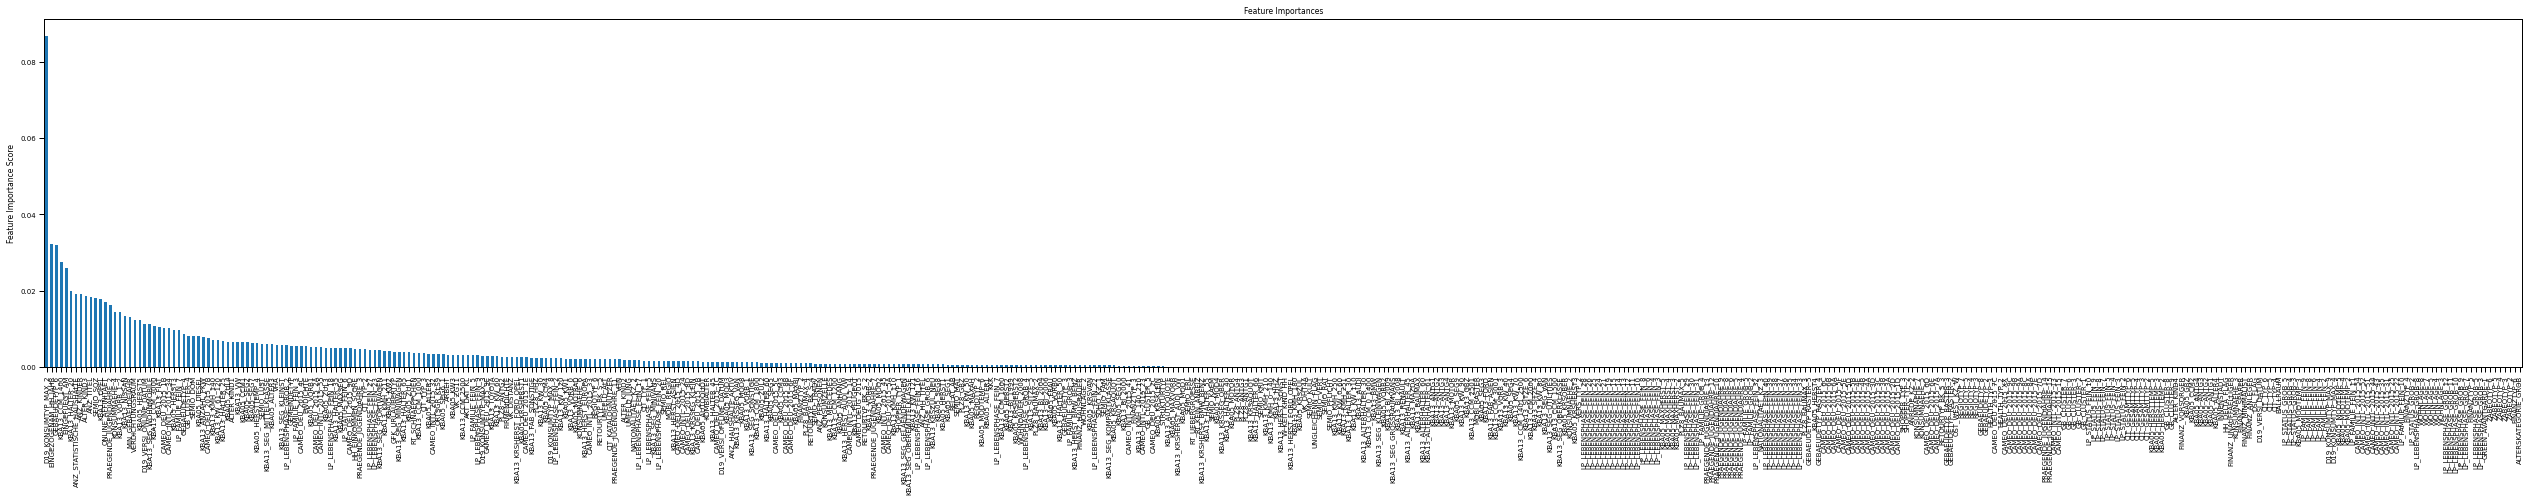

In [54]:
# Add GB_CLUSTER to list of categorical columns
updated_cat_cols = cat_cols.copy()

if 'GB_CLUSTER' not in updated_cat_cols:
    updated_cat_cols.append('GB_CLUSTER')

# Gather predictors
predictors = [c for c in mailout_train.columns if c != target_col]

# Define full preprocessing pipeline (with full categorical encoding including cluster features)
full_preprocessing_pipeline = Pipeline([
    ('col_transformer', ColumnTransformer([
        ('one_hot', OneHotEncoder(drop='first'), updated_cat_cols)
    ], remainder='passthrough')),
    ('scaler', StandardScaler())
])

reg_pipeline = Pipeline([
    ('preprocess', full_preprocessing_pipeline),
    ('reg', GradientBoostingRegressor(random_state=seed))
])

model, cv_results = fit_model(reg_pipeline, mailout_train, predictors, target_col, cat_cols=updated_cat_cols, perform_cv=True, print_feat_importance=True, cv_folds=5)
result_history['Feature engineered'] = cv_results[0]['mean']

In [55]:
result_history

{'Default GB': 0.6746062141566501, 'Feature engineered': 0.6785618996090992}

# Fine tuning
The next step is fine tuning the selected model architecture. We'll use this previous result as a baseline for CV scores comparison.
We'll set some initial guesses for the `min_samples_split`, `max_features`, `max_depth`, `subsample` parameters (those will be refined later). Then we'll fix a somewhat arbitrary learning rate and figure out the optimal number of estimators for that configuration. That will be the base for further tuning the remaining parameters.

In [56]:
# Rule of thumb for min_samples_split and max_features
print(f'Rule of thumb for min_samples_split (5% of all samples) =', .05 * len(mailout_train))
print(f'Rule of thumb for max_features (40% of all features) =', .4 * reg_pipeline.steps[-1][1].n_features_in_)

Rule of thumb for min_samples_split (5% of all samples) = 2148.1
Rule of thumb for max_features (40% of all features) = 202.4


In [57]:
# Fix learning rate and determine an optimum number of estimators

estimator_params = {
    'reg__learning_rate': [.1],
    'reg__n_estimators': list(range(20, 81, 10)),
    'reg__min_samples_split': [2000],
    'reg__min_samples_leaf': [50],
    'reg__max_depth': [8], 
    'reg__max_features': ['sqrt'],
    'reg__subsample': [0.8],
    'reg__random_state': [seed],
}

est_cv = GridSearchCV(reg_pipeline, param_grid=estimator_params, scoring='roc_auc', n_jobs=-1, verbose=3, cv=5)
est_cv.fit(mailout_train[predictors], mailout_train[target_col])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('col_transformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('one_hot',
                                                                                          OneHotEncoder(drop='first'),
                                                                                          ['KONSUMNAEHE',
                                                                                           'ANREDE_KZ',
                                                                                           'SHOPPER_TYP',
                                                                                           'KBA05_SEG6',
                                                                                           'CAMEO_DEU_2015',
 

In [58]:
from pprint import pprint
print('params =')
pprint(est_cv.best_params_)
print('\nROC AUC =', est_cv.best_score_)
result_history['Initial guesses'] = est_cv.best_score_

params =
{'reg__learning_rate': 0.1,
 'reg__max_depth': 8,
 'reg__max_features': 'sqrt',
 'reg__min_samples_leaf': 50,
 'reg__min_samples_split': 2000,
 'reg__n_estimators': 60,
 'reg__random_state': 42,
 'reg__subsample': 0.8}

ROC AUC = 0.6858152019258053


In [48]:
def get_cv_results(cv, idx_param='param_reg__n_estimators'):
    """Prints CV results and returns a formatted dataframe with the scores indexed by the selected parameter"""
    print(cv.best_params_)
    mean_scores, std_scores, idx = cv.cv_results_['mean_test_score'], cv.cv_results_['std_test_score'], cv.cv_results_[idx_param]
    return pd.DataFrame({'mean_score': mean_scores, 'std_scores': std_scores}, index=idx).sort_values('mean_score', ascending=False)

get_cv_results(est_cv)

{'reg__learning_rate': 0.1, 'reg__max_depth': 8, 'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 50, 'reg__min_samples_split': 2000, 'reg__n_estimators': 60, 'reg__random_state': 42, 'reg__subsample': 0.8}


,mean_score,std_scores
60,0.685815,0.027532
40,0.685008,0.028790
50,0.684926,0.029991
80,0.684818,0.026909
70,0.684103,0.027594
20,0.683809,0.024907
30,0.682945,0.028778


In [93]:
sample_depth_params = {
    'reg__learning_rate': [.1],
    'reg__n_estimators': [60],
    'reg__min_samples_split': list(range(1500, 5001, 250)),
    'reg__min_samples_leaf': [50],
    'reg__max_depth': list(range(3, 10, 1)),
    'reg__max_features': ['sqrt'],
    'reg__subsample': [0.8],
    'reg__random_state': [seed],
}

sample_depth_cv = GridSearchCV(reg_pipeline, param_grid=sample_depth_params, scoring='roc_auc', n_jobs=-1, verbose=3, cv=5)
sample_depth_cv.fit(mailout_train[predictors], mailout_train[target_col])


Fitting 5 folds for each of 105 candidates, totalling 525 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('col_transformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('one_hot',
                                                                                          OneHotEncoder(drop='first'),
                                                                                          ['KONSUMNAEHE',
                                                                                           'ANREDE_KZ',
                                                                                           'SHOPPER_TYP',
                                                                                           'KBA05_SEG6',
                                                                                           'CAMEO_DEU_2015',
 

In [94]:
get_cv_results(sample_depth_cv, idx_param='param_reg__min_samples_split').head()

{'reg__learning_rate': 0.1, 'reg__max_depth': 8, 'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 50, 'reg__min_samples_split': 2000, 'reg__n_estimators': 60, 'reg__random_state': 42, 'reg__subsample': 0.8}


,mean_score,std_scores
2000,0.685815,0.027532
4250,0.682740,0.025733
2750,0.682520,0.027476
4250,0.682481,0.032175
4500,0.682305,0.031267


In [96]:
get_cv_results(sample_depth_cv, idx_param='param_reg__max_depth').head()

{'reg__learning_rate': 0.1, 'reg__max_depth': 8, 'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 50, 'reg__min_samples_split': 2000, 'reg__n_estimators': 60, 'reg__random_state': 42, 'reg__subsample': 0.8}


,mean_score,std_scores
8,0.685815,0.027532
7,0.682740,0.025733
6,0.682520,0.027476
4,0.682481,0.032175
4,0.682305,0.031267


In [97]:
result_history['Max depth and min samples split'] = get_cv_results(sample_depth_cv, idx_param='param_reg__max_depth').iloc[0]['mean_score']
result_history

{'reg__learning_rate': 0.1, 'reg__max_depth': 8, 'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 50, 'reg__min_samples_split': 2000, 'reg__n_estimators': 60, 'reg__random_state': 42, 'reg__subsample': 0.8}


{'Default GB': 0.6746062141566501,
 'Feature engineered': 0.6785618996090992,
 'Initial guesses': 0.6858152019258053,
 'Max depth and min samples split': 0.6858152019258053,
 'Min samples leaf': 0.6827397704507161,
 'Subsample': 0.6833586905808883,
 'Max features': 0.6870733899356057}

In [98]:
samples_leaf_params = {
    'reg__learning_rate': [.1],
    'reg__n_estimators': [60],
    'reg__min_samples_split': [2000],
    'reg__min_samples_leaf': list(range(20, 71, 10)),
    'reg__max_depth': [8],
    'reg__max_features': ['sqrt'],
    'reg__subsample': [0.8],
    'reg__random_state': [seed],
}

samples_leaf_cv = GridSearchCV(reg_pipeline, param_grid=samples_leaf_params, scoring='roc_auc', n_jobs=-1, verbose=3, cv=5)
samples_leaf_cv.fit(mailout_train[predictors], mailout_train[target_col])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('col_transformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('one_hot',
                                                                                          OneHotEncoder(drop='first'),
                                                                                          ['KONSUMNAEHE',
                                                                                           'ANREDE_KZ',
                                                                                           'SHOPPER_TYP',
                                                                                           'KBA05_SEG6',
                                                                                           'CAMEO_DEU_2015',
 

In [99]:
get_cv_results(samples_leaf_cv, idx_param='param_reg__min_samples_leaf').head()

{'reg__learning_rate': 0.1, 'reg__max_depth': 8, 'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 50, 'reg__min_samples_split': 2000, 'reg__n_estimators': 60, 'reg__random_state': 42, 'reg__subsample': 0.8}


,mean_score,std_scores
50,0.685815,0.027532
60,0.675896,0.018285
30,0.668581,0.016374
70,0.666456,0.023286
40,0.665363,0.011598


In [100]:
result_history['Min samples leaf'] = get_cv_results(samples_leaf_cv, idx_param='param_reg__min_samples_leaf').iloc[0]['mean_score']
result_history

{'reg__learning_rate': 0.1, 'reg__max_depth': 8, 'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 50, 'reg__min_samples_split': 2000, 'reg__n_estimators': 60, 'reg__random_state': 42, 'reg__subsample': 0.8}


{'Default GB': 0.6746062141566501,
 'Feature engineered': 0.6785618996090992,
 'Initial guesses': 0.6858152019258053,
 'Max depth and min samples split': 0.6858152019258053,
 'Min samples leaf': 0.6858152019258053,
 'Subsample': 0.6833586905808883,
 'Max features': 0.6870733899356057}

In [101]:
np.sqrt(reg_pipeline.steps[-1][1].n_features_in_)

22.494443758403985

In [103]:
max_feats_params = {
    'reg__learning_rate': [.1],
    'reg__n_estimators': [60],
    'reg__min_samples_split': [2000],
    'reg__min_samples_leaf': [50],
    'reg__max_depth': [8],
    'reg__max_features': ['sqrt'] + list(range(10, 151, 10)),
    'reg__subsample': [0.8],
    'reg__random_state': [seed],
}

max_feats_cv = GridSearchCV(reg_pipeline, param_grid=max_feats_params, scoring='roc_auc', n_jobs=-1, verbose=3, cv=5)
max_feats_cv.fit(mailout_train[predictors], mailout_train[target_col])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('col_transformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('one_hot',
                                                                                          OneHotEncoder(drop='first'),
                                                                                          ['KONSUMNAEHE',
                                                                                           'ANREDE_KZ',
                                                                                           'SHOPPER_TYP',
                                                                                           'KBA05_SEG6',
                                                                                           'CAMEO_DEU_2015',
 

In [107]:
get_cv_results(max_feats_cv, idx_param='param_reg__max_features').head()

{'reg__learning_rate': 0.1, 'reg__max_depth': 8, 'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 50, 'reg__min_samples_split': 2000, 'reg__n_estimators': 60, 'reg__random_state': 42, 'reg__subsample': 0.8}


,mean_score,std_scores
sqrt,0.685815,0.027532
30,0.678969,0.022376
110,0.672796,0.011396
50,0.672553,0.028495
90,0.670457,0.007579


In [105]:
result_history['Max features'] = get_cv_results(max_feats_cv, idx_param='param_reg__max_features').iloc[0]['mean_score']
result_history

{'reg__learning_rate': 0.1, 'reg__max_depth': 8, 'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 50, 'reg__min_samples_split': 2000, 'reg__n_estimators': 60, 'reg__random_state': 42, 'reg__subsample': 0.8}


{'Default GB': 0.6746062141566501,
 'Feature engineered': 0.6785618996090992,
 'Initial guesses': 0.6858152019258053,
 'Max depth and min samples split': 0.6858152019258053,
 'Min samples leaf': 0.6858152019258053,
 'Subsample': 0.6833586905808883,
 'Max features': 0.6858152019258053}

In [110]:
subsample_params = {
    'reg__learning_rate': [.1],
    'reg__n_estimators': [60],
    'reg__min_samples_split': [2000],
    'reg__min_samples_leaf': [50],
    'reg__max_depth': [8],
    'reg__max_features': ['sqrt'],
    'reg__subsample': np.arange(.6, .95, .05),
    'reg__random_state': [seed],
}

subsample_cv = GridSearchCV(reg_pipeline, param_grid=subsample_params, scoring='roc_auc', n_jobs=-1, verbose=3, cv=5)
subsample_cv.fit(mailout_train[predictors], mailout_train[target_col])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('col_transformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('one_hot',
                                                                                          OneHotEncoder(drop='first'),
                                                                                          ['KONSUMNAEHE',
                                                                                           'ANREDE_KZ',
                                                                                           'SHOPPER_TYP',
                                                                                           'KBA05_SEG6',
                                                                                           'CAMEO_DEU_2015',
 

In [111]:
get_cv_results(subsample_cv, idx_param='param_reg__subsample').head()

{'reg__learning_rate': 0.1, 'reg__max_depth': 8, 'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 50, 'reg__min_samples_split': 2000, 'reg__n_estimators': 60, 'reg__random_state': 42, 'reg__subsample': 0.8000000000000002}


,mean_score,std_scores
0.80,0.685815,0.027532
0.75,0.673095,0.019374
0.85,0.667966,0.025372
0.90,0.667806,0.012656
0.60,0.660991,0.021839


In [112]:
result_history['Subsample'] = get_cv_results(subsample_cv, idx_param='param_reg__subsample').iloc[0]['mean_score']
result_history

{'reg__learning_rate': 0.1, 'reg__max_depth': 8, 'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 50, 'reg__min_samples_split': 2000, 'reg__n_estimators': 60, 'reg__random_state': 42, 'reg__subsample': 0.8000000000000002}


{'Default GB': 0.6746062141566501,
 'Feature engineered': 0.6785618996090992,
 'Initial guesses': 0.6858152019258053,
 'Max depth and min samples split': 0.6858152019258053,
 'Min samples leaf': 0.6858152019258053,
 'Subsample': 0.6858152019258053,
 'Max features': 0.6858152019258053}

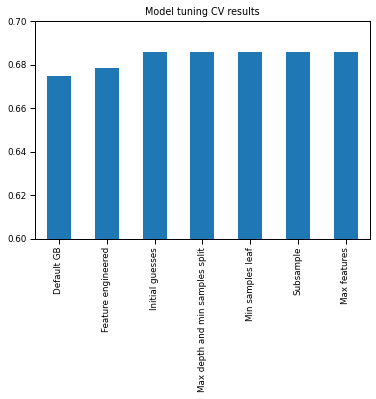

In [119]:
sns.set_context('paper', font_scale=1.0)
pd.Series(result_history, name='Tuning results').plot.bar(title='Model tuning CV results')
plt.ylim([.6, .7]);

# Refit and submit predictions
Finally, we'll perform a fit on the tuned model and submit the predictions to get the public leaderboard score. 

After that, we'll start increasing the number of estimators and lowering the learning rate proportionally to check if there are 

Training results (same dataset train/test):
               tuned_GB
roc_auc_score  0.896496
CV Results (5 folds):
              0
count  5.000000
mean   0.685815
std    0.030782
min    0.657055
25%    0.657326
50%    0.678606
75%    0.714738
max    0.721351


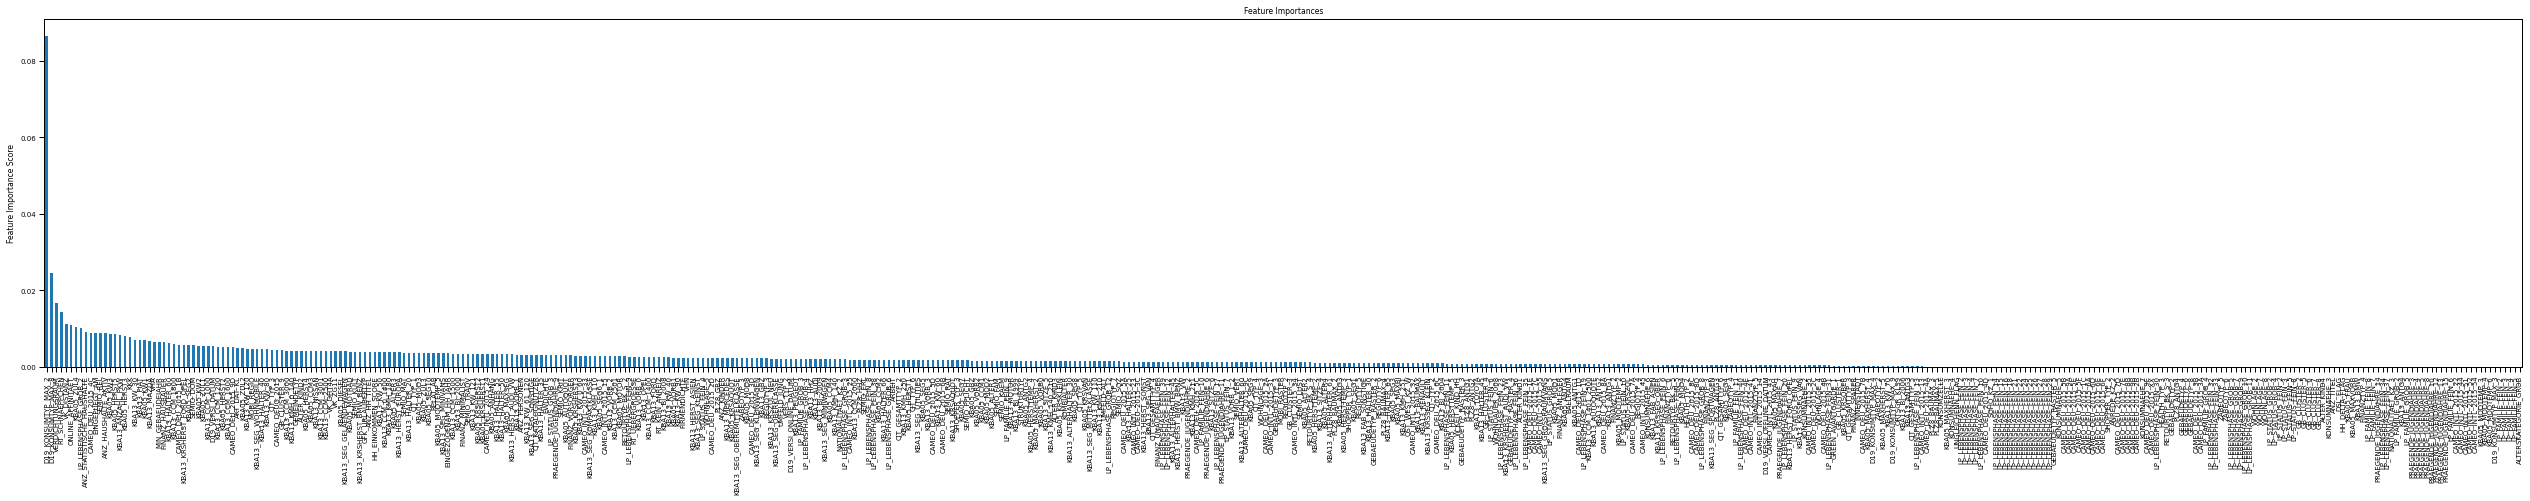

In [114]:
reg_pipeline.set_params(**subsample_cv.best_params_)

tuned_gb, fine_tuned_cv_results = fit_model(reg_pipeline, mailout_train, predictors, target_col, cat_cols=updated_cat_cols, perform_cv=True, print_feat_importance=True, cv_folds=5, model_name='tuned_GB')

In [120]:
mailout_test = pd.read_csv('data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = preprocess(mailout_test)

d:\Code\udacity\udacity_ds_capstone\.venv\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


	Raw data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB

*** Dropping columns/rows and imputing missing values...
	Missing values in df before imputing: 2142333
	Missing values in df now: 0

	Before optimization:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42833 entries, 1754 to 68898
Columns: 293 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: datetime64[ns](1), float64(261), int64(29), object(2)
memory usage: 96.1+ MB

	After optimization:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42833 entries, 1754 to 68898
Columns: 293 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: int16(5), int64(1), int8(285), object(2)
memory usage: 13.4+ MB


In [122]:
test_clusters = pd.Series(clustering_pipeline.predict(mailout_test), index=mailout_test.index, name='GB_CLUSTER')
mailout_test['GB_CLUSTER'] = test_clusters

In [123]:
y_pred = reg_pipeline.predict(mailout_test[predictors])
pd.DataFrame(y_pred, index=mailout_test.index, columns=['RESPONSE']).to_csv('data/subs/predictions_v8_factor1.csv')

Training results (same dataset train/test):
               tuned_GB
roc_auc_score  0.910642
CV Results (5 folds):
              0
count  5.000000
mean   0.693023
std    0.032288
min    0.648110
25%    0.670464
50%    0.707576
75%    0.715473
max    0.723489


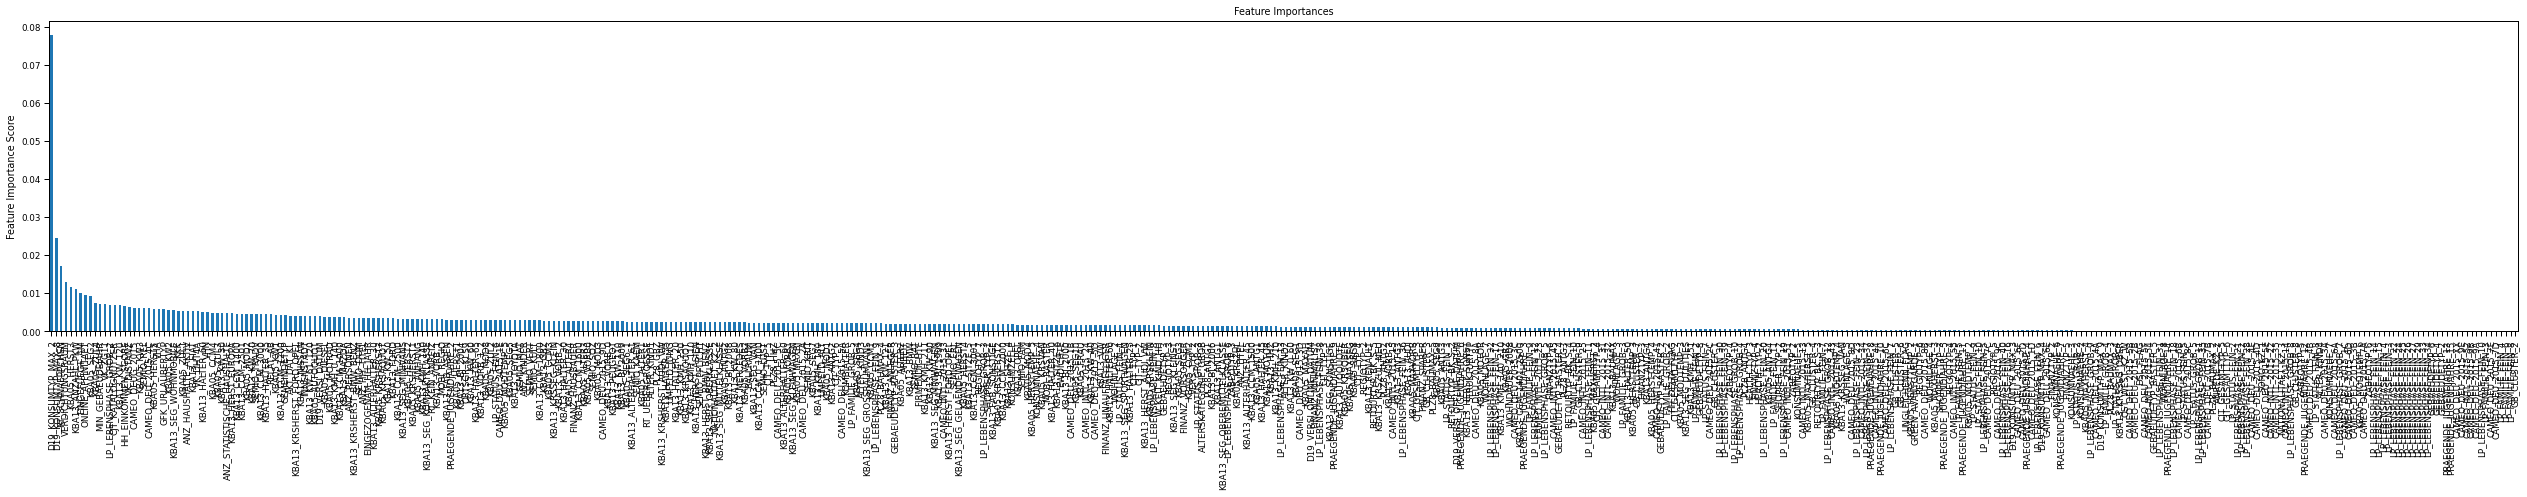

In [124]:
base_n_estimators = 60
base_learning_rate = 0.1
factor = 5

reg_pipeline.set_params(reg__n_estimators=base_n_estimators * factor, reg__learning_rate=base_learning_rate / factor)
tuned_gb, fine_tuned_cv_results = fit_model(reg_pipeline, mailout_train, predictors, target_col, cat_cols=updated_cat_cols, perform_cv=True, print_feat_importance=True, cv_folds=5, model_name='tuned_GB')

y_pred = reg_pipeline.predict(mailout_test[predictors])
pd.DataFrame(y_pred, index=mailout_test.index, columns=['RESPONSE']).to_csv(f'data/subs/predictions_v8_factor{factor}.csv')

In [129]:
result_history['Fine tuned factor 5'] = fine_tuned_cv_results[0]['mean']
result_history

{'Default GB': 0.6746062141566501,
 'Feature engineered': 0.6785618996090992,
 'Initial guesses': 0.6858152019258053,
 'Max depth and min samples split': 0.6858152019258053,
 'Min samples leaf': 0.6858152019258053,
 'Subsample': 0.6858152019258053,
 'Max features': 0.6858152019258053,
 'Fine tuned factor 5': 0.6930227072149048}

Training results (same dataset train/test):
               tuned_GB
roc_auc_score   0.90905
CV Results (5 folds):
              0
count  5.000000
mean   0.693662
std    0.029046
min    0.653850
25%    0.674637
50%    0.705883
75%    0.707174
max    0.726766


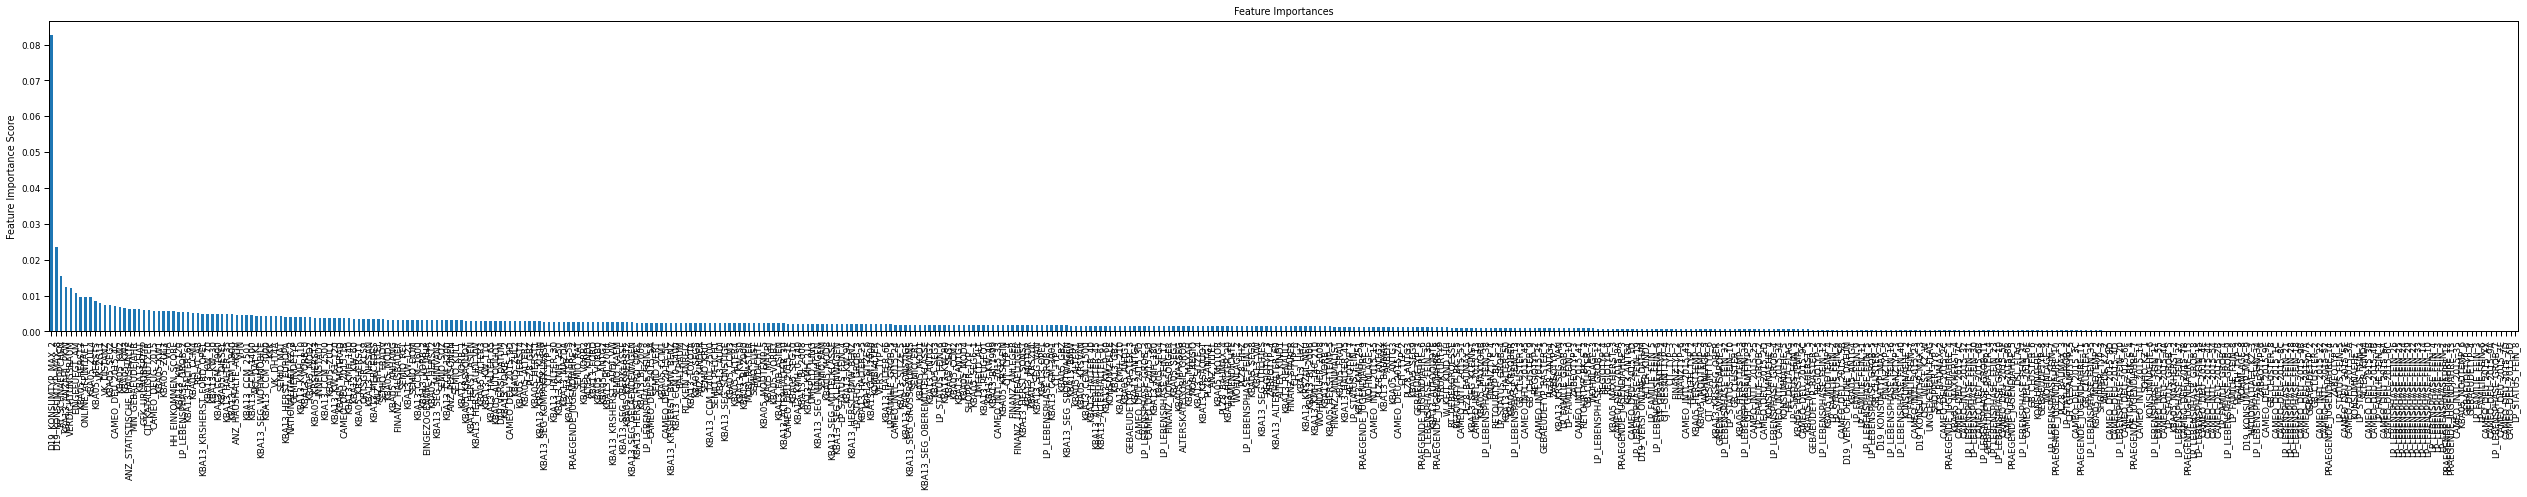

In [130]:
factor = 10

reg_pipeline.set_params(reg__n_estimators=base_n_estimators * factor, reg__learning_rate=base_learning_rate / factor)
tuned_gb, fine_tuned_cv_results = fit_model(reg_pipeline, mailout_train, predictors, target_col, cat_cols=updated_cat_cols, perform_cv=True, print_feat_importance=True, cv_folds=5, model_name='tuned_GB')
result_history['Fine tuned factor 10'] = fine_tuned_cv_results[0]['mean']

y_pred = reg_pipeline.predict(mailout_test[predictors])
pd.DataFrame(y_pred, index=mailout_test.index, columns=['RESPONSE']).to_csv(f'data/subs/predictions_v8_factor{factor}.csv')

Training results (same dataset train/test):
               tuned_GB
roc_auc_score      0.91
CV Results (5 folds):
              0
count  5.000000
mean   0.692902
std    0.028546
min    0.654192
25%    0.675808
50%    0.699213
75%    0.707544
max    0.727753


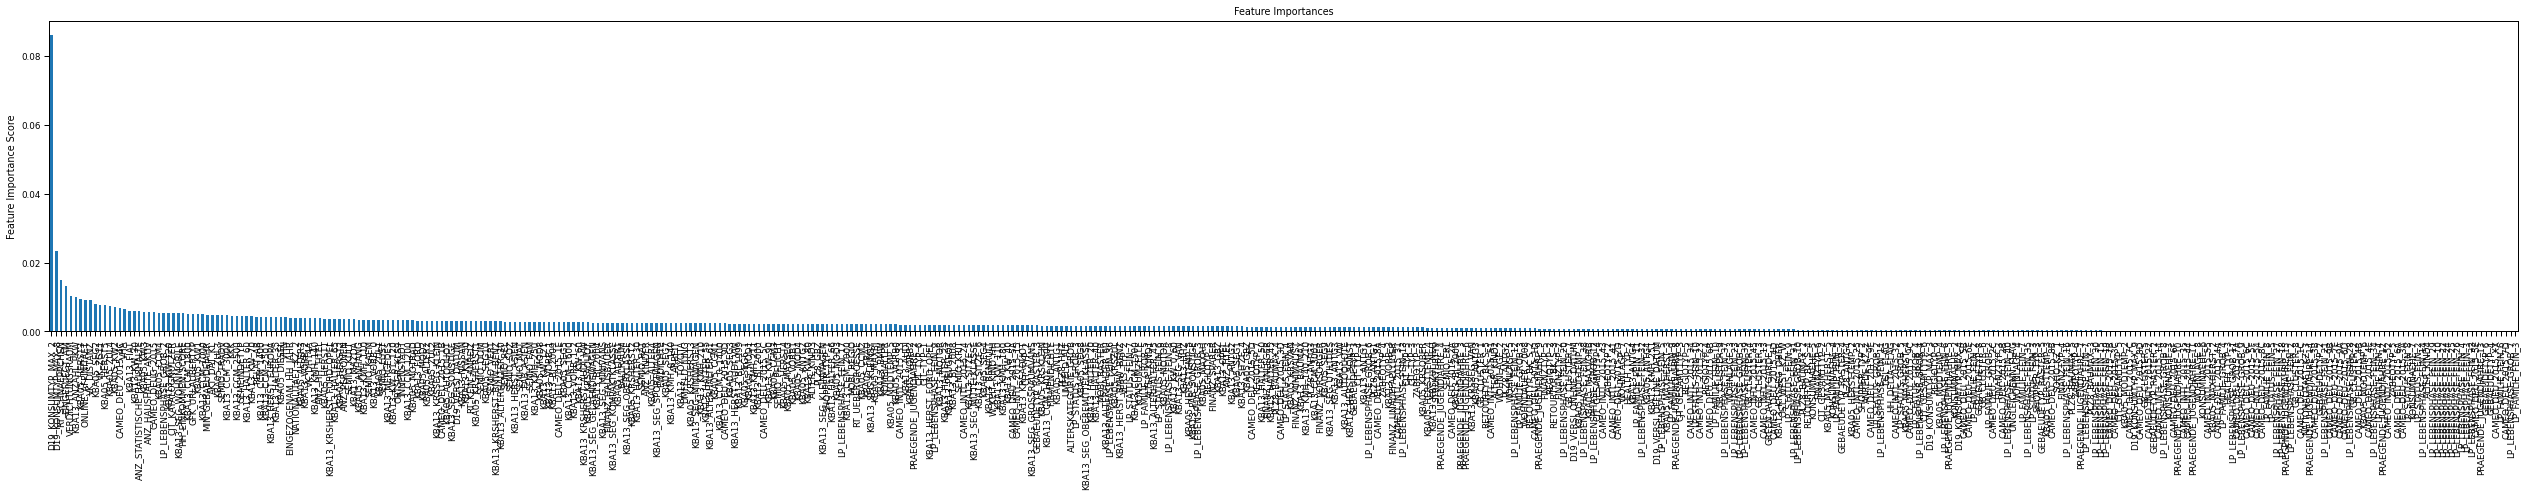

In [131]:
factor = 20

reg_pipeline.set_params(reg__n_estimators=base_n_estimators * factor, reg__learning_rate=base_learning_rate / factor)
tuned_gb, fine_tuned_cv_results = fit_model(reg_pipeline, mailout_train, predictors, target_col, cat_cols=updated_cat_cols, perform_cv=True, print_feat_importance=True, cv_folds=5, model_name='tuned_GB')
result_history['Fine tuned factor 20'] = fine_tuned_cv_results[0]['mean']

y_pred = reg_pipeline.predict(mailout_test[predictors])
pd.DataFrame(y_pred, index=mailout_test.index, columns=['RESPONSE']).to_csv(f'data/subs/predictions_v8_factor{factor}.csv')

Training results (same dataset train/test):
               tuned_GB
roc_auc_score  0.911227
CV Results (5 folds):
              0
count  5.000000
mean   0.694964
std    0.027744
min    0.658479
25%    0.676679
50%    0.699915
75%    0.711274
max    0.728473


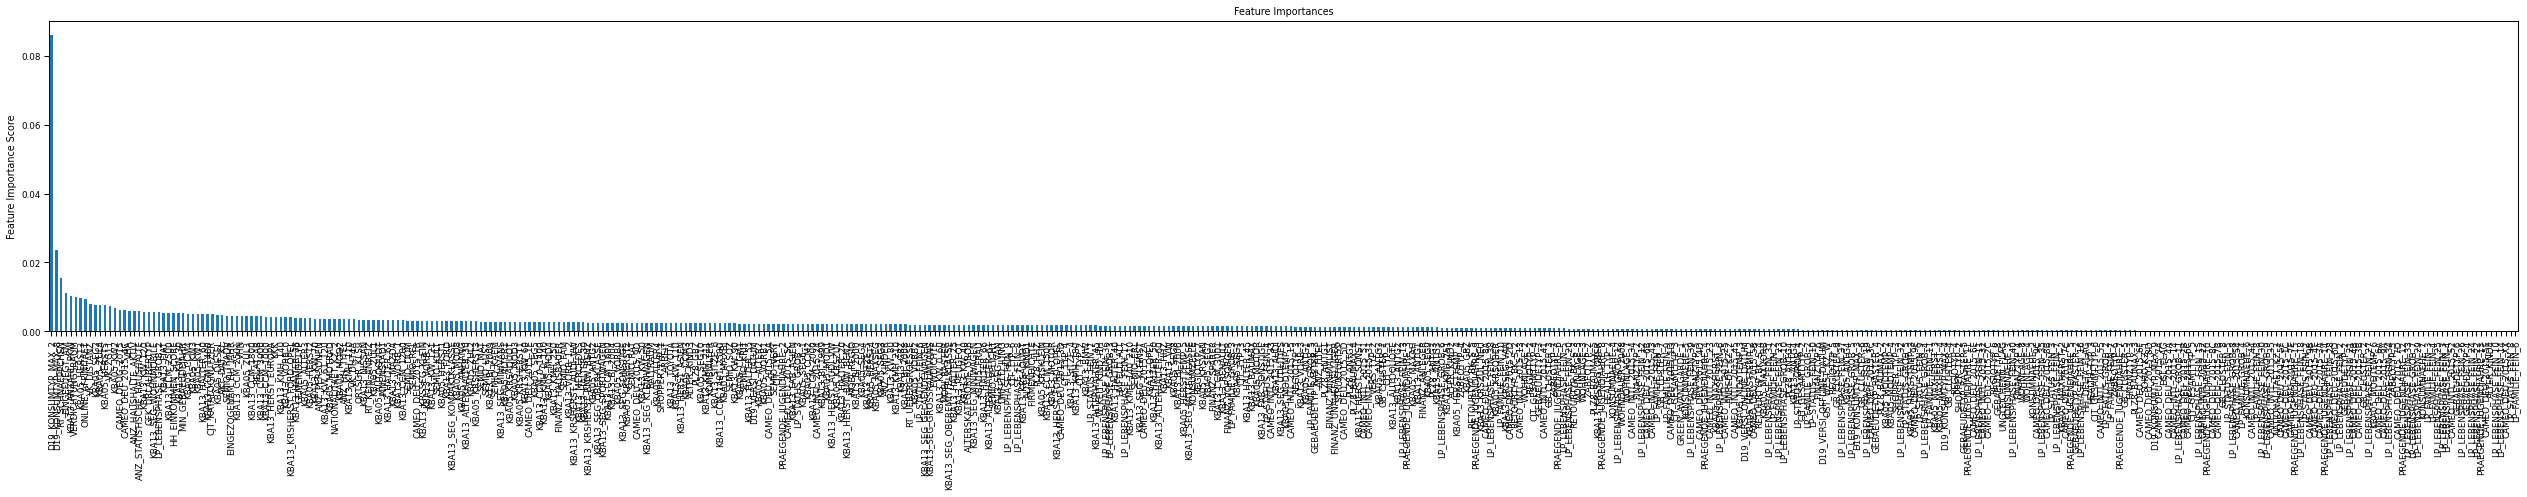

In [136]:
factor = 50

reg_pipeline.set_params(reg__n_estimators=base_n_estimators * factor, reg__learning_rate=base_learning_rate / factor)
tuned_gb, fine_tuned_cv_results = fit_model(reg_pipeline, mailout_train, predictors, target_col, cat_cols=updated_cat_cols, perform_cv=True, print_feat_importance=True, cv_folds=5, model_name='tuned_GB')
result_history['Fine tuned factor 20'] = fine_tuned_cv_results[0]['mean']

y_pred = reg_pipeline.predict(mailout_test[predictors])
pd.DataFrame(y_pred, index=mailout_test.index, columns=['RESPONSE']).to_csv(f'data/subs/predictions_v8_factor{factor}.csv')

In [144]:
result_history['Fine tuned factor 1 LB score'] = 0.70143
result_history['Fine tuned factor 5 LB score'] = 0.70698
result_history['Fine tuned factor 10 LB score'] = 0.71078
result_history['Fine tuned factor 20 LB score'] = 0.71835
result_history['Fine tuned factor 50 LB score'] = 0.71955
result_history


{'Default GB': 0.6746062141566501,
 'Feature engineered': 0.6785618996090992,
 'Initial guesses': 0.6858152019258053,
 'Max depth and min samples split': 0.6858152019258053,
 'Min samples leaf': 0.6858152019258053,
 'Subsample': 0.6858152019258053,
 'Max features': 0.6858152019258053,
 'Fine tuned factor 5': 0.6930227072149048,
 'Fine tuned factor 10': 0.6936620803710839,
 'Fine tuned factor 20': 0.6949639988618788,
 'Fine tuned factor 1 LB score': 0.70143,
 'Fine tuned factor 5 LB score': 0.70698,
 'Fine tuned factor 10 LB score': 0.71078,
 'Fine tuned factor 20 LB score': 0.71835,
 'Fine tuned factor 50 LB score': 0.71955}

In [143]:
dump(reg_pipeline, 'models/top_performing_regressor.joblib')

['models/top_performing_regressor.joblib']

# Conclusion

(0.65, 0.75)

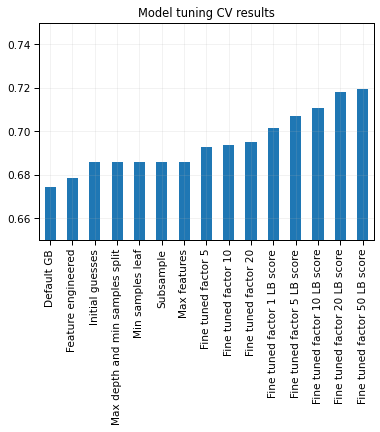

In [142]:
sns.set_context('paper', font_scale=1.2)
pd.Series(result_history, name='Tuning results').plot.bar(title='Model tuning CV results')
plt.grid(alpha=0.2)
plt.ylim([.65, .75]);


The parameter optimization step was not able to improve much in relation to the initial guesses (which only backs the hypothesis that the "rules of thumb" are a great starting point). New predictions were submitted to the competition for each new number of estimators generated in the final step of tuning. There were significant increases in performance for each configuration.